In [45]:
def imports():
    import pandas as pd
    import numpy as np

    from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout
    from tensorflow.keras.optimizers import Adam
    from sklearn.preprocessing import MinMaxScaler

In [3]:
def select_df(File_path, ProductCode, PlantCode, Sales_Channel, freq, interpolate = True, Dates_col = True):
    
    import pandas as pd
    import numpy as np
    
    df = pd.read_csv(File_path, parse_dates=[0])
    
    df.index = df['Date']
    df = df.sort_index()
    
    df = df[(df['ProductCode'] == ProductCode) & (df['PlantCode'] == PlantCode)& (df['Sales_Channel']== Sales_Channel)]
    df = df.resample(freq).mean()
    
    if interpolate == True:
        df = df.interpolate(method = 'spline', order = 2)
    
    if Dates_col == True:
        df['Dates'] = df.index

    return df

In [4]:
df = select_df(File_path='Sales Data.txt', ProductCode=7000158, PlantCode='Hyderabad - CFA', Sales_Channel='CP-GT', freq='B',
              interpolate=True)

C:\Users\FQ467WA\AppData\Local\Temp\ipykernel_12004\3053481124.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample(freq).mean()


In [5]:
df

,ProductCode,Plant,Sales_Qty,Sales_Value,Dates
Date,,,,,
2020-12-04,7000158.0,7011.0,149.000000,14032.570000,2020-12-04
2020-12-07,7000158.0,7011.0,100.000000,9885.080000,2020-12-07
2020-12-08,7000158.0,7011.0,121.069679,11839.520447,2020-12-08
2020-12-09,7000158.0,7011.0,182.000000,17656.500000,2020-12-09
2020-12-10,7000158.0,7011.0,246.000000,23800.790000,2020-12-10
...,...,...,...,...,...
2023-06-22,7000158.0,7011.0,461.672756,51503.245387,2023-06-22
2023-06-23,7000158.0,7011.0,521.000000,61592.020000,2023-06-23
2023-06-26,7000158.0,7011.0,-154.431961,-16263.730262,2023-06-26


In [6]:
def orders(data, lags, duration):
   
    from statsmodels.tsa.seasonal import seasonal_decompose
    from pandas.plotting import autocorrelation_plot
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    
    seasonal_decompose(data.iloc[:duration], model = 'additive').plot()
    
    plot_acf(data, lags = lags)
    
    plot_pacf(data, lags = lags)
    
    print('ACF is for MA - q, PACF is for AR - p and Trend is for d - p, d, q')

ACF is for MA - q, PACF is for AR - p and Trend is for d - p, d, q


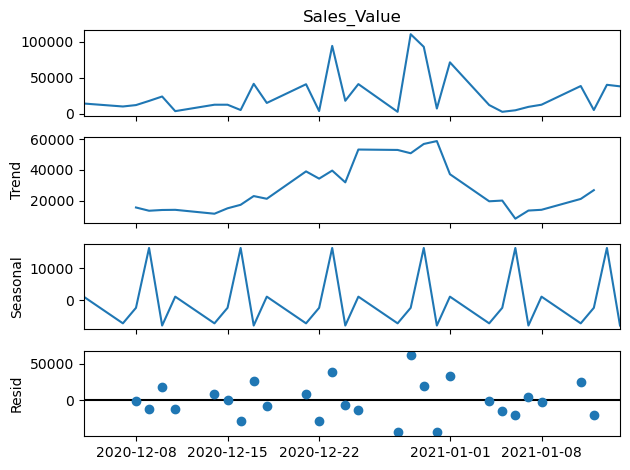

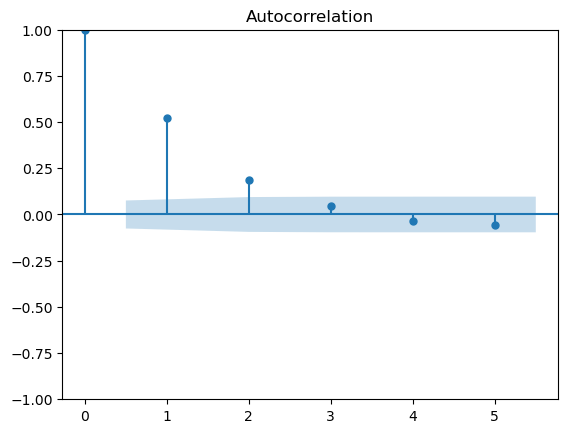

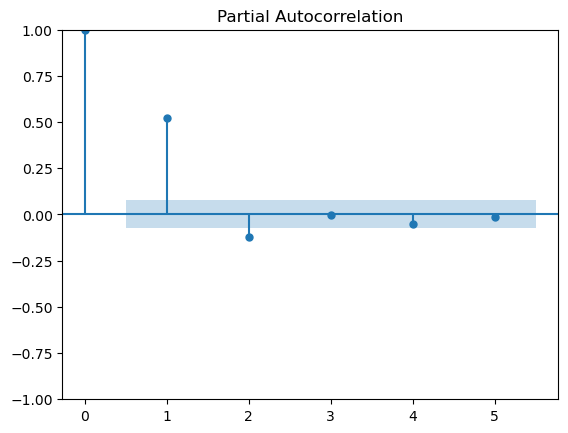

In [7]:
orders(data = df['Sales_Value'],lags=5, duration=30)

In [8]:
def train_test_split(data, train_size):
    
    train_size = int(data.shape[0]*train_size)
    
    train, test = data.iloc[:train_size], data.iloc[train_size:]
    
    return train, test

In [9]:
train, test = train_test_split(df['Sales_Value'], train_size= 0.8)

In [10]:
def differencing(data, lag):
    data = data.shift(lag)
    
    return data.iloc[lag:]

In [11]:
def arima(data, p, d, q, summary = False):
    model = ARIMA(data, order = (p, d, q)).fit()
    
    if summary == True:
        print(model.summary())
    
    return model

In [12]:
arima = arima(data=df['Sales_Value'], p = 1, d = 1, q = 2, summary=True)

                               SARIMAX Results                                
Dep. Variable:            Sales_Value   No. Observations:                  669
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -8088.892
Date:                Mon, 21 Aug 2023   AIC                          16185.783
Time:                        15:03:05   BIC                          16203.800
Sample:                    12-04-2020   HQIC                         16192.763
                         - 06-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3678      0.062      5.963      0.000       0.247       0.489
ma.L1         -0.7756      0.064    -12.184      0.000      -0.900      -0.651
ma.L2         -0.2231      0.059     -3.809      0.0

In [13]:
def model_pred(model, train, test):
    
    pred = model.predict(start = len(train), end = len(train)+len(test)-1)
    
    return pred

In [14]:
def metrics(actual, pred, mae = True, mape = True, mse = True, plot = True):
    from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
    if mae == True:
        print('Mean Absolute Error: ', mean_absolute_error(actual, pred))
    if mape == True:
        print('Mean Absolute Percentage Error: ', mean_absolute_percentage_error(actual, pred))
    if mse == True:
        print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(actual, pred)))
        
    if plot == True:
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 7))
        plt.plot(actual, label = 'Actual', c = 'g', alpha = 0.5, ls = '--')
        plt.plot(pred, label = 'Predictions', c = 'r', alpha = 0.5)
        plt.legend()

In [15]:
pred = model_pred(arima, train, test)

Mean Absolute Error:  30080.704057632687
Mean Absolute Percentage Error:  3.417556733591394
Root Mean Squared Error:  40024.841913607845


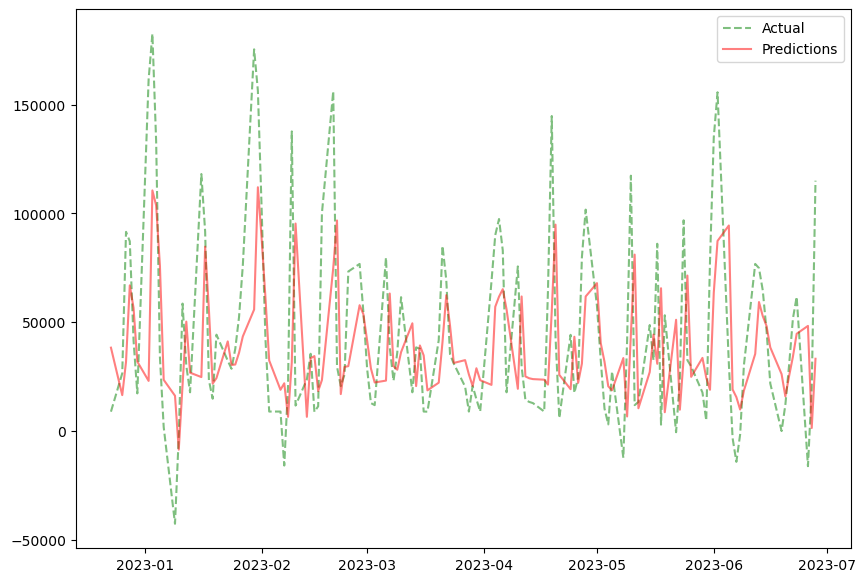

In [16]:
metrics(test, pred)

In [17]:
def sarimax(data, p, d, q, m, summary = False, ):
    model = SARIMAX(data, order = (p, d, q), seasonal_order=(1,1,1,m)).fit()
    
    if summary == True:
        print(model.summary())
    
    return model

In [18]:
sarimax = sarimax(data=df['Sales_Value'], p = 1, d = 1, q = 2, m=5, summary=True)

                                      SARIMAX Results                                      
Dep. Variable:                         Sales_Value   No. Observations:                  669
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 5)   Log Likelihood               -8152.615
Date:                             Mon, 21 Aug 2023   AIC                          16317.230
Time:                                     15:03:06   BIC                          16344.211
Sample:                                 12-04-2020   HQIC                         16327.686
                                      - 06-28-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3598      0.151      2.376      0.018       0.063       0.657
ma.L1         -0.7582      

In [19]:
pred = model_pred(sarimax, train, test)

Mean Absolute Error:  30275.28142306931
Mean Absolute Percentage Error:  3.7393408748995625
Root Mean Squared Error:  40497.10614224862


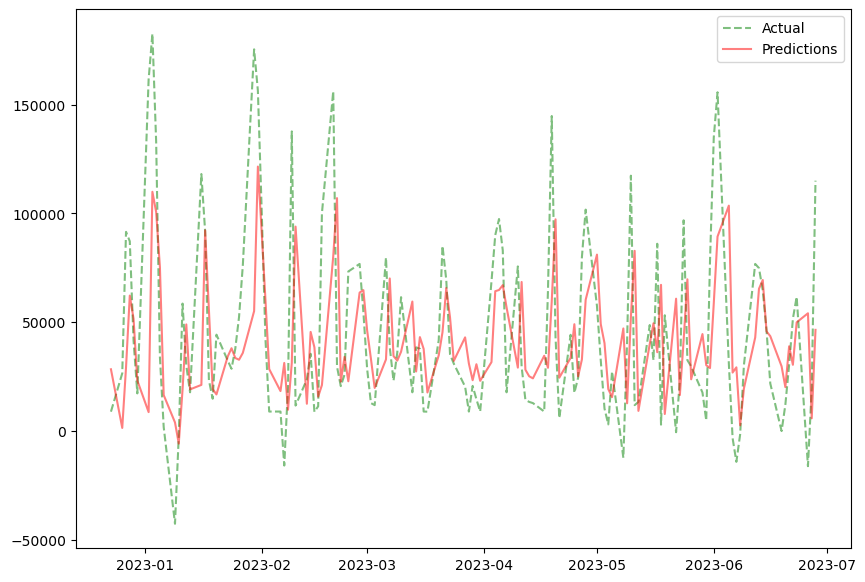

In [20]:
metrics(test, pred)

In [32]:
def lstm_rnn(df, col_name, date_col, train_size, plot = True, metrics = True):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout
    from tensorflow.keras.optimizers import Adam
    from sklearn.preprocessing import MinMaxScaler
    
    dataSize = len(df)
    df.head()
    
    dataMat = df[col_name].values.reshape(dataSize,1)
    dataMat.shape
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaledDataMat = scaler.fit_transform(dataMat)
    
    train_split = train_size

    train_size = int(train_split * dataSize)

    trainData = scaledDataMat[:train_size]
    valData = scaledDataMat[train_size:]

    print('Train data size: ', trainData.shape)
    print('Val data size: ', valData.shape)
    
    def createDataset(dataset, time_step=1):
        dataX, dataY = [], []
    
        for i in range(len(dataset)-time_step):
            dataX.append(dataset[i:(i+time_step)])
            dataY.append(dataset[i + time_step])
        return np.array(dataX), np.array(dataY)

    n_past = 4

    X_train,y_train = createDataset(trainData, time_step=n_past)
    X_val,y_val = createDataset(valData, time_step=n_past)

    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(n_past,1)))
    model.add(LSTM(64, return_sequences=False, input_shape=(n_past,1)))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',optimizer='adam')
    history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,batch_size=1,verbose=1, callbacks=[callback])
    
    y_train_hat = scaler.inverse_transform(model.predict(X_train))

    y_val_hat = scaler.inverse_transform(model.predict(X_val))
    
    train_shift = n_past

    test_shift = train_shift + len(y_train_hat) + n_past
    
    if plot == True:
        plt.figure(figsize = (10,6))

        plt.plot(df[date_col], df[col_name], color='g', label="Original Data", alpha = 0.5, ls = '--')
        plt.plot(df[date_col][train_shift: test_shift-n_past], y_train_hat, color='r', label="Train data Pred", alpha = 0.8)
        plt.plot(df[date_col][test_shift:], y_val_hat, color='y', label="Val Data Pred", alpha = 0.8)

        plt.legend()
    
    if metrics == True:
        from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
        
        def metrics(actual, pred, mae = True, mape = True, mse = True, plot = True):
            if mae == True:
                print('Mean Absolute Error: ', mean_absolute_error(actual, pred))
            if mape == True:
                print('Mean Absolute Percentage Error: ', mean_absolute_percentage_error(actual, pred))
            if mse == True:
                print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(actual, pred)))
        
            if plot == True:
                import matplotlib.pyplot as plt
        
                plt.figure(figsize=(10, 7))
                plt.plot(actual, label = 'Actual', c = 'g', alpha = 0.5, ls = '--')
                plt.plot(pred, label = 'Predictions', c = 'r', alpha = 0.5)
                plt.legend()
        
        metrics(scaler.inverse_transform(y_val), y_val_hat)
        
    print()
    
    return model,scaler, y_val, y_val_hat

In [33]:
df = select_df(File_path='Sales Data.txt', ProductCode=7000158, PlantCode='Hyderabad - CFA', Sales_Channel='CP-GT', freq='B',
             interpolate=True)

C:\Users\FQ467WA\AppData\Local\Temp\ipykernel_12004\3053481124.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample(freq).mean()


Train data size:  (535, 1)
Val data size:  (134, 1)
(531, 4, 1) (531, 1)
(130, 4, 1) (130, 1)
Epoch 1/50
531/531 [==============================] - 5s 4ms/step - loss: 0.0097 - val_loss: 0.0056
Epoch 2/50
531/531 [==============================] - 1s 3ms/step - loss: 0.0079 - val_loss: 0.0052
Epoch 3/50
531/531 [==============================] - 1s 3ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 4/50
531/531 [==============================] - 1s 3ms/step - loss: 0.0069 - val_loss: 0.0044
Epoch 5/50
531/531 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0043
Epoch 6/50
531/531 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 7/50
531/531 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 8/50
531/531 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 9/50
531/531 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 

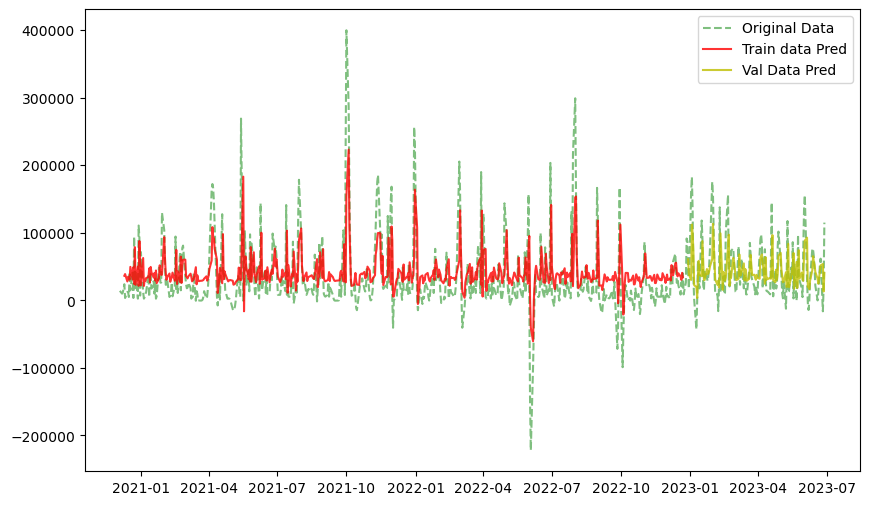

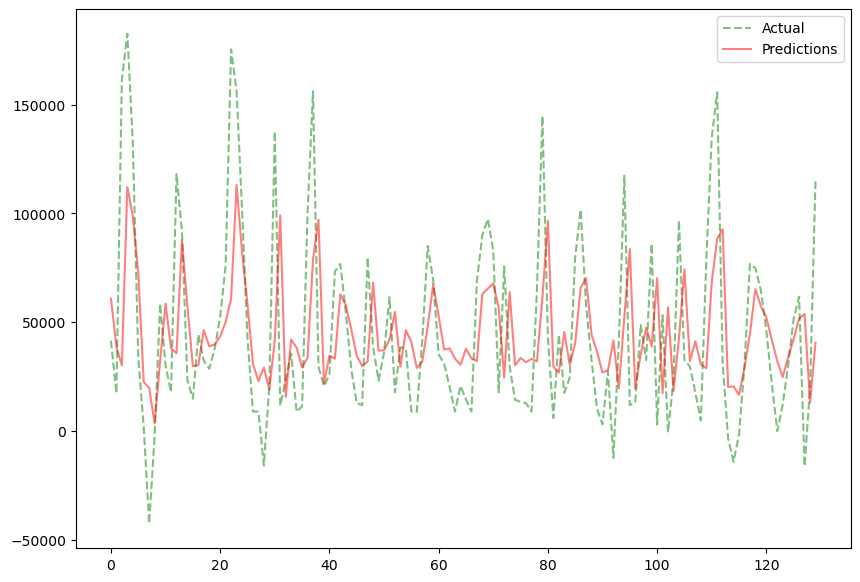

In [34]:
model_1, scaler, y_val, y_val_pred =  lstm_rnn(df = df, col_name = 'Sales_Value', date_col='Dates', train_size= 0.8)

In [42]:
model_1.predict([[[0.32610522],
       [0.36280942],
       [0.33711125],
       [0.3450934 ]]])

1/1 [==============================] - 0s 32ms/step


array([[0.40251446]], dtype=float32)

In [44]:
scaler.inverse_transform([[0.32610522],
       [0.36280942],
       [0.33711125],
       [0.3450934 ]])

array([[-19226.1289358 ],
       [  3583.63905556],
       [-12386.44871376],
       [ -7425.95401364]])